In this chapter I’m switching from batch solvers to stochastic optimization. Instead of fitting all data at once, the model updates its parameters incrementally. That makes it fast and memory-efficient, and it also lets me train in an online fashion with partial_fit. I’ll start with a quick baseline using logistic loss, then look at epochs, over/underfitting, and finally compare hinge loss.


# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Preparing the data

In [2]:
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [3]:
fish_X = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']]
fish_y = fish['Species']

In [4]:
train_X, test_X, train_y, test_y = train_test_split(
    fish_X, fish_y, random_state = 42)

In [5]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train_X)
test_scaled = ss.transform(test_X)

# Baseline: SGDClassifier with logistic loss

In [6]:
sc = SGDClassifier(loss = 'log_loss', max_iter = 10, random_state = 42)
sc.fit(train_scaled, train_y)

print(sc.score(train_scaled, train_y))
print(sc.score(test_scaled, test_y))

0.8319327731092437
0.775


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


With just 10 iterations the accuracy is modest. The warning about maximum iterations not reaching convergence is expected at this setting and simply means I should either call partial_fit more or increase max_iter.

In [7]:
# train with partial fit by training one epoch

sc.partial_fit(train_scaled, train_y)

print(sc.score(train_scaled, train_y))
print(sc.score(test_scaled, test_y))

0.8151260504201681
0.8


# Epochs, over/underfitting, and the learning curve

Let's track accuracy across many updates. For partial_fit on multiclass data, I must pass the full class list at least once.

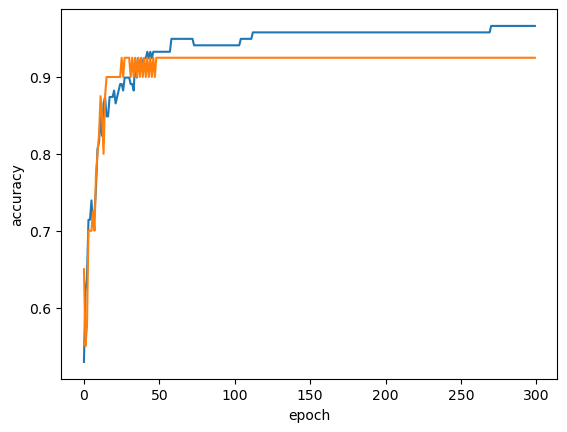

In [8]:
sc = SGDClassifier(loss = 'log_loss', random_state = 42)
train_score = []
test_score = []

classes = np.unique(train_y)
for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_y, classes = classes)
    train_score.append(sc.score(train_scaled, train_y))
    test_score.append(sc.score(test_scaled, test_y))

#and plot
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

The curve shows the typical pattern: as epochs increase, train accuracy climbs steadily; test accuracy improves and then stabilizes. If I pushed epochs too far without regularization adjustments, I’d expect a widening gap (overfitting). Here, the lines settle together, which is a good sign.

To get a clean fit in one go, I turn off the default early stopping and raise iterations:

In [9]:
sc = SGDClassifier(loss = 'log_loss', max_iter = 100, tol = None, random_state = 42)
sc.fit(train_scaled, train_y)

print(sc.score(train_scaled, train_y))
print(sc.score(test_scaled, test_y))

0.957983193277311
0.925


This reaches a strong solution. The gap between train and test is small, which looks well-balanced.

# Trying hinge loss (linear SVM with SGD)

loss='hinge' gives a linear SVM(support vector machine) trained via SGD. Everything else stays the same.

In [10]:
sc = SGDClassifier(loss = 'hinge', max_iter = 100, tol = None, random_state = 42)
sc.fit(train_scaled, train_y)

print(sc.score(train_scaled, train_y))
print(sc.score(test_scaled, test_y))

0.9495798319327731
0.925


Hinge loss slightly lowers training accuracy but matches the test accuracy from logistic loss. That’s consistent with a margin-maximizing objective being a bit more conservative on the training set while generalizing at a similar level.

# What I learned

SGD changes how I think about training. Rather than waiting for a batch solver to finish, I can iterate quickly, observe the curve, and decide when to stop. With logistic loss, a small number of epochs underfits by adding more epochs or calling partial_fit improves the model, but the right way to check progress is to plot train and test accuracy over time. Turning off early stopping (tol=None) and giving the optimizer enough iterations leads to a stable solution in one shot. Comparing losses showed that hinge and logistic behave similarly on this dataset. Logistic fit was slightly higher on train while hinge kept the same test accuracy with a tighter margin-based objective. Overall, the combination of scaling, incremental updates, and explicit control over epochs makes SGD a practical default when I need speed, online learning, or a simple linear baseline before moving to heavier models.